# Toy R-NVP Studies

**Goal:** When I'm adding layers of complexity to the model, it's worthwhile seeing if the *simplest* model will work, so I'm going to start off playing with the real NVP module that's inside the [MAF repo]() that I've been using for my other experiments to see if I can first just extend it to 1d.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
#import uproot
from sklearn.preprocessing import StandardScaler

from trainFlows import train, validate

import os
import sys
sys.path.append("../../pytorch-flows")
import flows as fnn

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from scipy.stats import entropy, pearsonr, skew, kstest

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
%%bash
nvidia-smi

Sun Apr  5 14:47:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 28%   50C    P2   119W / 250W |   7753MiB / 11178MiB |     57%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 26%   46C    P2    77W / 250W |   9177MiB / 12196MiB |     13%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

## Step 1: Make a dataset

In [15]:
from torch.distributions.normal import Normal
?Normal

In [19]:
?m.sample

In [25]:
x = m.sample(torch.Size((10000,)))
y = x+3

In [110]:
class toy1d(Dataset):
    
    def __init__(self, N=10000):
        """
        
        Inputs:
        - myFile: The name of the hdf5 file with the pandas Dataframe
        - cols: The input variables of interest
        
        """
        
        m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        
        z = m.sample(torch.Size((N,)))
        self.x = z+3
        
        
    def __len__(self):
        return self.x.shape[0] 

    def __getitem__(self, idx):
        return self.x[idx]

In [108]:
def getDataLoaders(batch_size=128, N=10000):
    '''
    Generating data for training
    '''

    loader_train = DataLoader(toy1d(N), batch_size=batch_size)
    loader_val   = DataLoader(toy1d(N), batch_size=batch_size)
    loader_test  = DataLoader(toy1d(N), batch_size=batch_size)

    return loader_train, loader_val, loader_test

In [111]:
loader_train, loader_val, loader_test = getDataLoaders()

## Step 2: Make up a model

In [5]:
device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

In [76]:
mask = torch.ones([1]) 
mask = mask.unsqueeze(0).float().to(device)

In [77]:
mask

tensor([[1.]], device='cuda:8')

In [117]:
modules = []

num_inputs = 1
num_hidden = 64
num_cond_inputs = None

for _ in range(1):
        modules += [
            fnn.CouplingLayer(num_inputs, num_hidden, mask, num_cond_inputs),
            fnn.BatchNormFlow(num_inputs)
        ]
               
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [81]:
s_act='tanh'

activations = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh}
s_act_func = activations[s_act]

total_inputs = num_inputs


In [83]:
s = nn.Sequential(nn.Linear(total_inputs, num_hidden), s_act_func(),
                  nn.Linear(num_hidden, num_hidden), s_act_func(),
                  nn.Linear(num_hidden, num_inputs))

In [106]:
xi.shape

torch.Size([128, 1, 1])

In [85]:
s(xi).shape

torch.Size([128, 1, 1])

In [91]:
c = fnn.CouplingLayer(num_inputs, num_hidden, mask, num_cond_inputs)
c.to(device)

CouplingLayer(
  (scale_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (translate_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [113]:
xi = xi.to(device)

In [114]:
y, logdet = c(xi)

In [115]:
y.shape, logdet.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

In [105]:
?nn.Linear

In [118]:
model.log_probs(xi)

logdets torch.Size([128, 1])
direct mode
logdet torch.Size([128, 1])
logdets torch.Size([128, 1])
logdet torch.Size([1])
logdets torch.Size([128, 1])


tensor([[-1.0482],
        [-1.0325],
        [-1.0550],
        [-0.9848],
        [-1.1562],
        [-1.4225],
        [-2.5822],
        [-3.6909],
        [-1.6929],
        [-0.9848],
        [-1.1075],
        [-0.9833],
        [-0.9949],
        [-1.0843],
        [-1.3632],
        [-0.9984],
        [-1.0132],
        [-1.0193],
        [-0.9859],
        [-2.8242],
        [-1.7548],
        [-1.8640],
        [-1.0110],
        [-1.3718],
        [-0.9898],
        [-1.0622],
        [-2.1654],
        [-2.0185],
        [-1.4851],
        [-0.9855],
        [-2.0013],
        [-1.1431],
        [-1.5921],
        [-1.6220],
        [-3.0131],
        [-1.1675],
        [-1.0473],
        [-1.0319],
        [-1.0078],
        [-1.0585],
        [-0.9940],
        [-0.9838],
        [-3.6838],
        [-1.0337],
        [-1.3135],
        [-0.9843],
        [-1.0443],
        [-1.2720],
        [-1.7399],
        [-0.9939],
        [-0.9843],
        [-1.0727],
        [-1.

## Step 3: Train the model









  0%|          | 0/79 [00:00<?, ?it/s]







Train, Log likelihood in nats: -189.860443: : 128it [00:00, 4433.10it/s]







Train, Log likelihood in nats: -185.681221: : 256it [00:00, 6166.39it/s]







Train, Log likelihood in nats: -185.529394: : 384it [00:00, 7108.86it/s]







Train, Log likelihood in nats: -183.472534: : 512it [00:00, 7747.25it/s]







Train, Log likelihood in nats: -183.782529: : 640it [00:00, 8298.72it/s]







Train, Log likelihood in nats: -184.113118: : 768it [00:00, 8750.48it/s]







Train, Log likelihood in nats: -185.061986: : 896it [00:00, 9175.22it/s]







Train, Log likelihood in nats: -185.061986: : 1024it [00:00, 9608.08it/s]







Train, Log likelihood in nats: -184.388678: : 1024it [00:00, 9608.08it/s]







Train, Log likelihood in nats: -181.697232: : 1152it [00:00, 9608.08it/s]







Train, Log likelihood in nats: -182.236356: : 1280it [00:00, 9608.08it/s]







Train, Log likelihood in nats: -182.372811: : 1408it [00:00, 9


Epoch: 0










Train, Log likelihood in nats: -181.428203: : 2304it [00:00, 9608.08it/s]







Train, Log likelihood in nats: -181.428203: : 2432it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.201239: : 2432it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.167584: : 2560it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.553891: : 2688it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.041050: : 2816it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.206140: : 2944it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.077603: : 3072it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.486650: : 3200it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.729962: : 3328it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.560060: : 3456it [00:00, 10488.12it/s]







Train, Log likelihood in nats: -181.540012: : 3584it [00:00, 10488.12it/s]







Train, Lo

Best validation at epoch 0: Average Log Likelihood in nats: -inf


## Step 4: Evaluate the model

In [131]:
s,n = model.sample(10000,returnNoise=True)
s = s.cpu().detach().numpy()
n = n.cpu().detach().numpy()

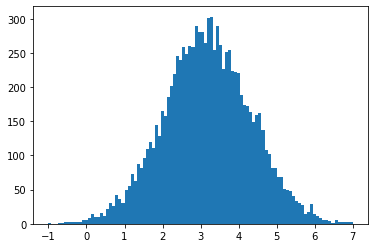

In [132]:
plt.hist(s,100,(-1,7))

plt.show()

Ok, this looks *nice* - next let's see if we can see *how* the individual points got morphed.

Or also, I could try playing around w/ a multi-modal function?

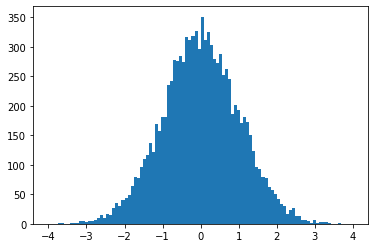

In [134]:
plt.hist(n,100,(-4,4))

plt.show()

In [137]:
s

array([[3.2815804],
       [1.1963164],
       [3.5252054],
       ...,
       [3.5651972],
       [2.5740397],
       [3.4765797]], dtype=float32)

In [138]:
n

array([[ 0.10234866],
       [-1.7290237 ],
       [ 0.31631103],
       ...,
       [ 0.3514337 ],
       [-0.51904523],
       [ 0.27360582]], dtype=float32)

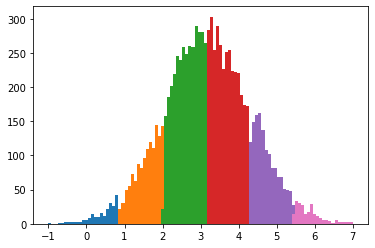

In [140]:
edges = [-4,-2,-1,0,1,2,4]

#hs = 

for c, zmin, zmax in zip(['C0','C1','C2','C3','C4','C6'],edges[:-1],edges[1:]):
    
    plt.hist(s[(n>zmin) & (n<zmax)],100,(-1,7),color=c,stacked=True)
    
plt.show()

Lovely! This is doing *exactly* what I wanted it to be doing!!

In [135]:
?plt.hist